# Обучение CNN классификатора

https://www.kaggle.com/datasets/asaniczka/pc-parts-images-dataset-classification - датасет

In [3]:
import kagglehub
import os
# Download latest version
datapath = kagglehub.dataset_download("asaniczka/pc-parts-images-dataset-classification") + '/pc_parts'
print("Path to dataset files:", datapath)

/Users/lvinnichenko/dev/torch/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/lvinnichenko/.cache/kagglehub/datasets/asaniczka/pc-parts-images-dataset-classification/versions/1/pc_parts


In [4]:
os.listdir(datapath), len(os.listdir(datapath))

(['headset',
  'motherboard',
  'monitor',
  'gpu',
  'microphone',
  'speakers',
  'cpu',
  'mouse',
  'case',
  'cables',
  'hdd',
  'webcam',
  'keyboard',
  'ram'],
 14)

In [5]:
import torch
import torch.nn as nn
import torchvision.transforms.v2 as transforms
from torch.utils.data import DataLoader
import torch.optim as optim

from tqdm import tqdm
import random
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from PIL import Image

%matplotlib inline
# Установка стилистики графиков
plt.style.use('ggplot')

In [6]:
# Установка Seed для воспроизводимости
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Создадим датасет:

`torch.utils.data.Dataset` - абстрактный класс, от которого необходимо наследоваться для реализации своего датасета.

**Методы для перезаписывания:**
- `__init__` - конструктор, необязательно прописывать, но является удобным и скорее правильным способом загрузки базовых данных.
- `__getitem__` - обязательный метод, принимает в себя аргумент index (индекс в данных). Должен возвращать данные, которые находятся по заданному индексу. Для задачи классификации - это изображение и метка класса, для задачи детекции - изображение и bounding box, для сегментации - изображение и маска.
- `__len__` - опциональный метод, но если необходимо использовать Dataloader'ы - то обязательный. Должен возвращать кол-во объектов в датасете, по сути, нужен, чтобы Dataloader мог вести корректную индексацию по датасету и не выходить за границы выборки.
- `__getitems__` - опциональный метод, принимает в себя список индексов в данных (indices). Должен возвращать список объектов по заданным индексам. Формат объектов такой же, как в `__getitem__`. Можно использовать, чтобы Dataloader получал сразу несколько элементов, что в некоторых случаях будет быстрее - так как будет возможность применять препроцессинг и аугментации сразу ко всем тензору, а не по отдельности.

**Описание абстрактного класса Dataset от Pytorch:**

An abstract class representing a :class:`Dataset`.

All datasets that represent a map from keys to data samples should subclass
it. All subclasses should overwrite :meth:`__getitem__`, supporting fetching a
data sample for a given key. Subclasses could also optionally overwrite
:meth:`__len__`, which is expected to return the size of the dataset by many
:class:`~torch.utils.data.Sampler` implementations and the default options
of :class:`~torch.utils.data.DataLoader`. Subclasses could also
optionally implement :meth:`__getitems__`, for speedup batched samples
loading. This method accepts list of indices of samples of batch and returns
list of samples.

.. note::
    :class:`~torch.utils.data.DataLoader` by default constructs an index
    sampler that yields integral indices.  To make it work with a map-style
    dataset with non-integral indices/keys, a custom sampler must be provided.


In [8]:
import os
from torch.utils.data import Dataset
from torchvision.io import decode_image, ImageReadMode
import functools

In [9]:
class DatasetPC(Dataset):
    @functools.cache
    @staticmethod
    def list_data_dir(root_dir):
        """
        Чтение данных из папки  только пути к файлам и метки классам. Сами изображения подгружаем в __getitem__.

        :return:
        1. Список, где каждый элемент - это кортеж (путь к файлу и метка класса).
        2. Список классов
        """
        # os.listdir(data_dir) - выдает названия всех файлов и папок внутри заданной папки data_dir
        # os.path.join(path1, path2) - соединяет строки, как пути, то есть результатом тут будет path1\path2
        data = []
        for label_index, label in enumerate(os.listdir(root_dir)):
            label_dir = os.path.join(root_dir, label)
            for filename in os.listdir(label_dir):
                filepath = os.path.join(label_dir, filename)
                data.append((filepath, label_index))

        return data, os.listdir(root_dir)

    @staticmethod
    def data_split(data, split_ratio):
        """
        Разделение списка данных на тренировочные и валидационные данные с сохранением пропорций классов.

        :return: Два списка: тренировочный и валидационный.
        """
        # Группируем данные по классам в словарь в формате (метка класса: список файлов)
        label_dict = {}
        for filepath, label in data:
            if label in label_dict:
                label_dict[label].append(filepath)
            else:
                label_dict[label] = [filepath]

        # Проходимся по всем группам (меткам класса) и делим на тренировочную и тестовую
        train_data = []
        valid_data = []
        for label, filepaths in label_dict.items():
            train_size = int(len(filepaths) * split_ratio)
            label_data = [(filepath, label) for filepath in filepaths]
            train_data.extend(label_data[:train_size])
            valid_data.extend(label_data[train_size:])

        return train_data, valid_data


    def __init__(self, root_dir, train=True, transform=None, split_ratio=0.8):
        """
        Инициализация класса DatasetPC.

        :param root_dir: Путь к директории с изображениями.
        :param train: Флаг, указывающий, является ли датасет тренировочным.
        :param transform: Трансформации, применяемые к изображениям.
        :param split_ratio: Доля данных, используемая для тренировки.
        """
        self.data, self.classes = DatasetPC.list_data_dir(root_dir) # Записываем данные из папки (пути к файлам и классы)
        train_data, valid_data = DatasetPC.data_split(self.data, split_ratio) # Разделяем на тренировочную и валидационную выборки
        self.data = train_data if train else valid_data # Выбираем какую выборку взять тренировочную или тестовую
        self.transform = transform # Записываем функцию для трансформации изображения


    def __len__(self):
        """
        Возвращает количество изображений в датасете.

        :return: Количество изображений.
        """
        return len(self.data)


    def __getitem__(self, index):
        """
        Возвращает изображение и метку по индексу.

        :param index: Индекс изображения.
        :return: Изображение и метка класса.
        """

        image_path, label = self.data[index]

        # from torchvision.io import decode_image, ImageReadMode
        image = decode_image(image_path, mode=ImageReadMode.RGB)
        if self.transform:
            image = self.transform(image)

        return image, label

In [10]:
data, classes = DatasetPC.list_data_dir(datapath)
data[10:20], data[1000:1010], data[-10:]

([('/Users/lvinnichenko/.cache/kagglehub/datasets/asaniczka/pc-parts-images-dataset-classification/versions/1/pc_parts/headset/215.jpg',
   0),
  ('/Users/lvinnichenko/.cache/kagglehub/datasets/asaniczka/pc-parts-images-dataset-classification/versions/1/pc_parts/headset/229.jpg',
   0),
  ('/Users/lvinnichenko/.cache/kagglehub/datasets/asaniczka/pc-parts-images-dataset-classification/versions/1/pc_parts/headset/177.jpg',
   0),
  ('/Users/lvinnichenko/.cache/kagglehub/datasets/asaniczka/pc-parts-images-dataset-classification/versions/1/pc_parts/headset/89.jpg',
   0),
  ('/Users/lvinnichenko/.cache/kagglehub/datasets/asaniczka/pc-parts-images-dataset-classification/versions/1/pc_parts/headset/163.jpg',
   0),
  ('/Users/lvinnichenko/.cache/kagglehub/datasets/asaniczka/pc-parts-images-dataset-classification/versions/1/pc_parts/headset/188.jpg',
   0),
  ('/Users/lvinnichenko/.cache/kagglehub/datasets/asaniczka/pc-parts-images-dataset-classification/versions/1/pc_parts/headset/76.jpg',
 

In [11]:
train_data, valid_data = DatasetPC.data_split(data, 0.8)

train_data

[('/Users/lvinnichenko/.cache/kagglehub/datasets/asaniczka/pc-parts-images-dataset-classification/versions/1/pc_parts/headset/63.jpg',
  0),
 ('/Users/lvinnichenko/.cache/kagglehub/datasets/asaniczka/pc-parts-images-dataset-classification/versions/1/pc_parts/headset/189.jpg',
  0),
 ('/Users/lvinnichenko/.cache/kagglehub/datasets/asaniczka/pc-parts-images-dataset-classification/versions/1/pc_parts/headset/77.jpg',
  0),
 ('/Users/lvinnichenko/.cache/kagglehub/datasets/asaniczka/pc-parts-images-dataset-classification/versions/1/pc_parts/headset/162.jpg',
  0),
 ('/Users/lvinnichenko/.cache/kagglehub/datasets/asaniczka/pc-parts-images-dataset-classification/versions/1/pc_parts/headset/176.jpg',
  0),
 ('/Users/lvinnichenko/.cache/kagglehub/datasets/asaniczka/pc-parts-images-dataset-classification/versions/1/pc_parts/headset/88.jpg',
  0),
 ('/Users/lvinnichenko/.cache/kagglehub/datasets/asaniczka/pc-parts-images-dataset-classification/versions/1/pc_parts/headset/228.jpg',
  0),
 ('/Users

In [12]:
len(train_data), len(valid_data), len(train_data) / len(valid_data)

(2616, 663, 3.9457013574660635)

In [13]:
from torch.utils.data import Dataset, random_split
from torchvision.datasets import ImageFolder

class DatasetPC(Dataset):
    def __init__(self, root_dir, train=True, transform=None, split_ratio=0.8, seed=42):
        """
        Инициализация класса DatasetPC.

        :param root_dir: Путь к директории с изображениями.
        :param train: Флаг, указывающий, является ли датасет тренировочным.
        :param transform: Трансформации, применяемые к изображениям.
        :param split_ratio: Доля данных, используемая для тренировки.
        :param seed: Значение seed для фиксации случайности.
        """
        self.root_dir = root_dir
        self.train = train
        self.transform = transform
        self.split_ratio = split_ratio
        self.seed = seed
        self.transform = transform

        # Загрузка всех изображений
        self.full_dataset = ImageFolder(root_dir, transform=None)
        self.classes = self.full_dataset.classes
        self.class_to_idx = self.full_dataset.class_to_idx

        # Разделение датасета на тренировочные и валидационные данные с сохранением пропорций классов
        self.train_dataset, self.val_dataset = self._split_dataset()
        self.dataset = self.train_dataset if self.train else self.val_dataset

    def _split_dataset(self):
        """
        Разделение датасета на тренировочные и валидационные данные с сохранением пропорций классов.

        :return: Два датасета: тренировочный и валидационный.
        """
        # Фиксация seed для воспроизводимости
        torch.manual_seed(self.seed)

        # Подсчет количества образцов для каждого класса
        class_counts = {cls: 0 for cls in self.classes}
        for _, label in self.full_dataset:
            class_counts[self.classes[label]] += 1

        # Расчет количества образцов для тренировки и валидации для каждого класса
        train_counts = {cls: int(self.split_ratio * count) for cls, count in class_counts.items()}
        val_counts = {cls: count - train_counts[cls] for cls, count in class_counts.items()}

        # Разделение датасета для каждого класса
        train_dataset, val_dataset = [], []
        for cls in self.classes:
            cls_indices = [i for i, (_, label) in enumerate(self.full_dataset) if self.classes[label] == cls]
            cls_train_indices, cls_val_indices = random_split(cls_indices, [train_counts[cls], val_counts[cls]])
            train_dataset.extend([self.full_dataset[i] for i in cls_train_indices])
            val_dataset.extend([self.full_dataset[i] for i in cls_val_indices])

        return train_dataset, val_dataset

    def __len__(self):
        """
        Возвращает количество изображений в датасете.

        :return: Количество изображений.
        """
        return len(self.dataset)

    def __getitem__(self, idx):
        """
        Возвращает изображение и метку по индексу.

        :param idx: Индекс изображения.
        :return: Изображение и метка.
        """
        image, label = self.dataset[idx]
        image = torch.from_numpy(np.array(image)).permute(2,0,1)
        if self.transform:
            image = self.transform(image)
        return image, label

In [14]:
from torchvision.datasets import ImageFolder

folder = ImageFolder(datapath, transform=None)

class_counts = {cls: 0 for cls in folder.classes}

for _, label in folder:
    class_counts[folder.classes[label]] += 1

train_counts = {cls: int(0.8 * count) for cls, count in class_counts.items()}
val_counts = {cls: count - train_counts[cls] for cls, count in class_counts.items()}

print(train_counts)
print(val_counts)

{'cables': 238, 'case': 225, 'cpu': 113, 'gpu': 124, 'hdd': 209, 'headset': 211, 'keyboard': 214, 'microphone': 171, 'monitor': 204, 'motherboard': 192, 'mouse': 168, 'ram': 180, 'speakers': 236, 'webcam': 131}
{'cables': 60, 'case': 57, 'cpu': 29, 'gpu': 32, 'hdd': 53, 'headset': 53, 'keyboard': 54, 'microphone': 43, 'monitor': 52, 'motherboard': 49, 'mouse': 42, 'ram': 46, 'speakers': 60, 'webcam': 33}


# Без особых аугментаций

In [15]:
dir(Dataset)

['__add__',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__firstlineno__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__static_attributes__',
 '__str__',
 '__subclasshook__',
 '__weakref__']

In [16]:
# Определим пути к данным

# Определим трансформации
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Создадим датасеты
train_dataset = DatasetPC(datapath, train=True, transform=train_transforms)
val_dataset = DatasetPC(datapath, train=False, transform=val_transforms)

# Создадим датагенераторы
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Список классов:

In [17]:
classes_list = train_dataset.classes
print(classes_list)

['cables', 'case', 'cpu', 'gpu', 'hdd', 'headset', 'keyboard', 'microphone', 'monitor', 'motherboard', 'mouse', 'ram', 'speakers', 'webcam']


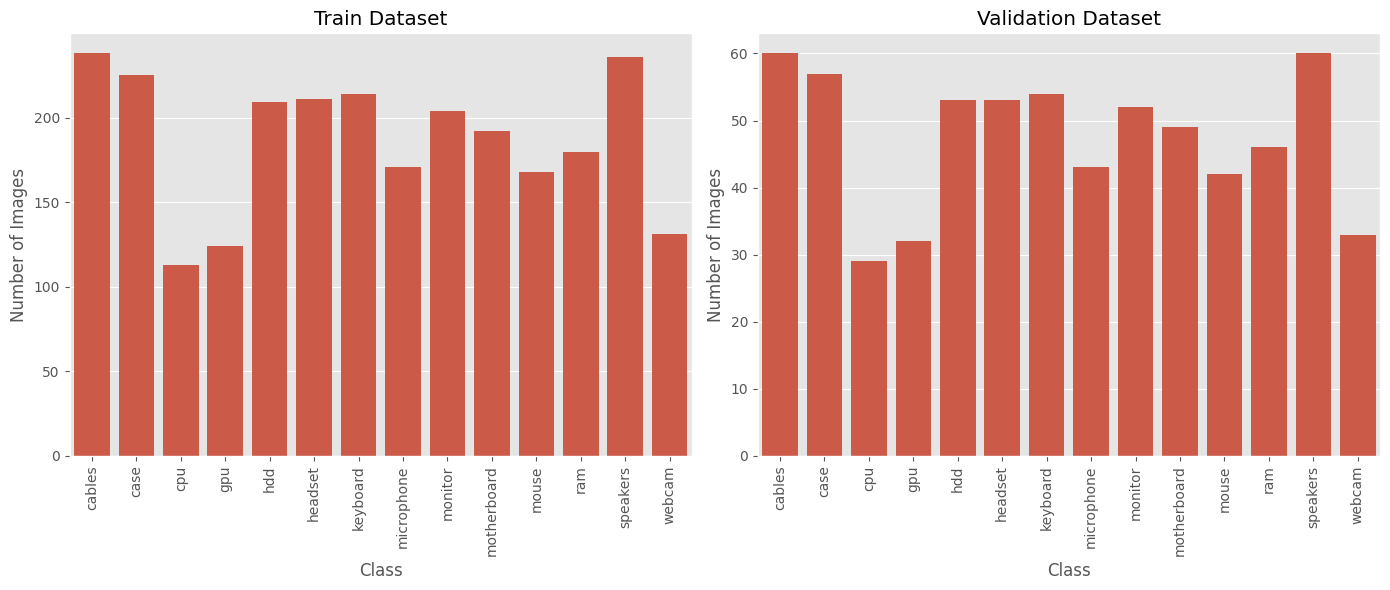

In [18]:
# Подсчитать количество изображений в каждом классе для обучающего набора данных
train_class_counts = np.zeros(len(train_dataset.classes))
for _, label in train_dataset:
    train_class_counts[label] += 1

# Подсчитать количество изображений в каждом классе для валидационного набора данных
val_class_counts = np.zeros(len(val_dataset.classes))
for _, label in val_dataset:
    val_class_counts[label] += 1

# Создать barplot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Barplot для обучающего набора данных
sns.barplot(x=train_dataset.classes, y=train_class_counts, ax=ax[0])
ax[0].set_title('Train Dataset')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Number of Images')
ax[0].tick_params(axis='x', rotation=90)

# Barplot для валидационного набора данных
sns.barplot(x=val_dataset.classes, y=val_class_counts, ax=ax[1])
ax[1].set_title('Validation Dataset')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Number of Images')
ax[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

Пример фоток после нормализации:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151556..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data

Images with class labels:


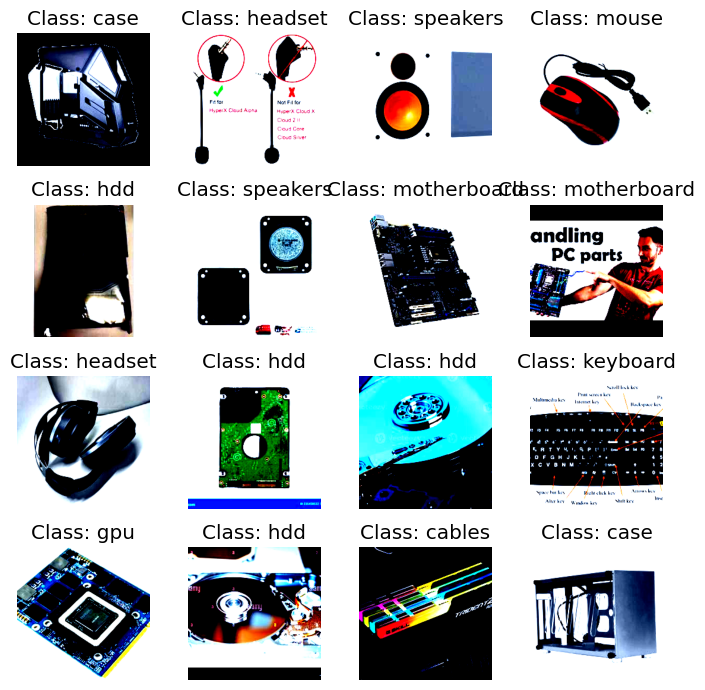

In [22]:
# Функция для отображения изображений из батча с метками классов
def show_images(images, labels, denormalize=False):
    if denormalize:
        # Обратное преобразование для нормализации
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        images = images.numpy().transpose((0, 2, 3, 1))
        images = std * images + mean
        images = np.clip(images, 0, 1)
    else:
        images = images.numpy().transpose((0, 2, 3, 1))

    fig, axes = plt.subplots(4, 4, figsize=(7, 7))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.set_title(f"Class: {classes_list[labels[i]]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Получение первого батча из тренировочного загрузчика данных
images, labels = next(iter(train_loader))

# Отображение изображений с восстановлением цветов и метками классов
print("Images with class labels:")
show_images(images, labels, denormalize=False)

Сколько в одной эпохе проходов по батчам:

In [23]:
len(train_loader), len(val_loader)

(41, 11)

In [24]:
img, label = next(iter(train_loader))

In [25]:
label

tensor([ 9,  8, 12,  5,  2, 12,  4, 10,  5,  4,  4, 12, 10, 12,  6,  8,  1,  8,
         6,  9, 11,  1,  7,  3,  6, 12,  4,  0,  9,  0,  2, 13, 10,  1, 10,  6,
         5,  4,  8,  6, 13, 12,  3,  1, 11,  6,  2,  0,  9,  5,  6,  9,  4,  0,
        13,  0,  0,  8,  5,  2,  7,  3,  3,  7])

Пример данных в датасете и даталоадере:

In [29]:
train_dataset[0]

# train_dataset.dataset

(tensor([[[ 1.8893,  1.9064,  1.9064,  ...,  1.6324,  1.3927,  1.2557],
          [ 1.9064,  1.9407,  1.9407,  ...,  1.1187,  1.1529,  1.2043],
          [ 1.9407,  1.9749,  1.9920,  ...,  0.3309,  0.5022,  0.5878],
          ...,
          [-1.8268, -1.8268, -1.8268,  ..., -1.7754, -1.6555, -1.3987],
          [-1.8097, -1.8097, -1.8097,  ..., -1.7925, -1.6727, -1.6727],
          [-1.8097, -1.8097, -1.8097,  ..., -1.7925, -1.8268, -1.7925]],
 
         [[ 1.3256,  1.3606,  1.3957,  ...,  1.3431,  1.5707,  1.7108],
          [ 1.3431,  1.3782,  1.4307,  ...,  1.0105,  1.3957,  1.6583],
          [ 1.3782,  1.4307,  1.4832,  ...,  0.4328,  0.7654,  0.9405],
          ...,
          [-1.7381, -1.7381, -1.7381,  ..., -1.6856, -1.5280, -1.2654],
          [-1.7206, -1.7206, -1.7206,  ..., -1.7206, -1.5630, -1.5280],
          [-1.7206, -1.7206, -1.7206,  ..., -1.7031, -1.7031, -1.6331]],
 
         [[ 1.2631,  1.2805,  1.3154,  ...,  1.4025,  1.5420,  1.5942],
          [ 1.2805,  1.3154,

In [27]:
next(iter(train_loader))

[tensor([[[[ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
           [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
           [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
           ...,
           [ 0.6734,  0.6392,  0.6392,  ...,  2.2489,  2.2489,  2.2489],
           [-0.1657, -0.1999, -0.2342,  ...,  2.2489,  2.2489,  2.2489],
           [ 1.8550,  1.8550,  1.8379,  ...,  2.2489,  2.2489,  2.2489]],
 
          [[ 2.3936,  2.3936,  2.3936,  ...,  2.4111,  2.4111,  2.4111],
           [ 2.4111,  2.4111,  2.4111,  ...,  2.4111,  2.4111,  2.4111],
           [ 2.4286,  2.4286,  2.4286,  ...,  2.4111,  2.4111,  2.4286],
           ...,
           [ 0.8179,  0.8004,  0.7829,  ...,  2.4286,  2.4286,  2.4286],
           [-0.0399, -0.0749, -0.1099,  ...,  2.4286,  2.4286,  2.4286],
           [ 2.0259,  2.0259,  2.0084,  ...,  2.4286,  2.4286,  2.4286]],
 
          [[ 2.6400,  2.6400,  2.6400,  ...,  2.6400,  2.6400,  2.6400],
           [ 

## Загрузим предобученную модель

https://pytorch.org/vision/main/models.html

https://huggingface.co/timm

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights

# Загрузим предварительно обученную модель ResNet18
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Для использования предобученной модели нам нужно поменять последний слой, чтобы он выдавал нужное кол-во классов (в данном датасете 12). Это можно сделать двумя способами:
1. Добавить новый полносвязный слой, в данной модели это будет слой с 1000 входными нейронами и 12 выходными.
2. Заменить последний слой, тогда получится слой с 512 входными нейронами и 12 выходными.

In [ ]:
# Первый подход
num_classes = len(classes_list)
model_seq = torch.nn.Sequential(model, nn.ReLU(), nn.Linear(model.fc.out_features, num_classes))
model_seq

Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [ ]:
model.fc = nn.Linear(model.fc.in_features, num_classes)

In [ ]:
model.fc

Linear(in_features=512, out_features=14, bias=True)

In [ ]:
# Заменим последний слой (fully connected) так, чтобы количество выходных каналов соответствовало N классам
num_classes = len(classes_list)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
model.eval()
model.to(device)
correct = 0
total = 0
with torch.no_grad():
    for images, labels in tqdm(val_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
val_accuracy = correct / total
print(val_accuracy)

  0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 11/11 [00:01<00:00,  7.93it/s]

0.06636500754147813


## Использование предобученных моделей

| Тип использования                | Fine-Tuning                                                                 | Transfer Learning                                                             |
|-----------------------|-----------------------------------------------------------------------------|-------------------------------------------------------------------------------|
| Задача             | Адаптировать веса модели к новой задаче                            | Переиспользовать знания из весов модели для решения новой задачи |
| Подход к обучению      | Обучаем все слои модели                                       | Часть первых слоев замораживаются, и обучаются только последние слои |
| Данные       | Обычно необходимо большое кол-во данных                     | Требуется не так много данных  |
| Когда использовать              | Когда есть много данных и имеются вычислительные ресурсы | Когда мало данных или не очень по вычислительным ресурсам. Также имеет смысл если новая задача похожа на задачу предобученной модели |
| Метрики            | Обычно лучше метрики                    | Обычно хуже метрики |

## Модель для fine-tune`а

In [ ]:
class ResNet18ForFineTune(nn.Module):

    def __init__(self):
        super().__init__()
        self.resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

model = ResNet18ForFineTune()

In [ ]:
# Валидация модели до обучения:

model.eval()
model.to(device)
correct = 0
total = 0
with torch.no_grad():
    for images, labels in tqdm(val_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
val_accuracy = correct / total
print(val_accuracy)

  0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 11/11 [00:07<00:00,  1.56it/s]

0.07239819004524888


# Обучение сети:

In [ ]:
def train(model, loss_fn, optimizer, dataloader):
    model.train()
    train_loss = 0
    train_acc = 0
    it_count = len(dataloader)
    with tqdm(total=it_count) as pbar:
        for batch, (images, labels) in enumerate(dataloader):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            train_loss += loss.item()
            train_acc += (outputs.argmax(dim=1) == labels).float().mean().item()

            # Backprpagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pbar.update(1)

            if batch % (it_count // 3) == 0:
                pbar.set_description(f"Train_loss: {round(train_loss / (batch + 1), 3)}" + f" Train_acc: {round(train_acc / (batch + 1), 3)}")

    return train_loss / it_count, train_acc / it_count


def test(model, loss_fn, dataloader):
    model.eval()
    test_loss = 0
    test_acc = 0
    it_count = len(dataloader)
    with tqdm(total=it_count) as pbar:
        with torch.no_grad():
            for batch, (images, labels) in enumerate(dataloader):
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                test_loss += loss.item()
                test_acc += (outputs.argmax(dim=1) == labels).float().mean().item()

                pbar.update(1)

                if batch % (it_count // 3) == 0:
                    pbar.set_description(f"Test_loss: {round(test_loss / (batch + 1), 3)}" + f" Test_acc: {round(test_acc / (batch + 1), 3)}")

    return test_loss / it_count, test_acc / it_count


def train_test_loop(model, loss_fn, optimizer, num_epochs):
    train_losses, test_losses = [], []
    train_accs, test_accs = [], []
    best_val_accuracy = 0

    model.to(device)
    for epoch in range(num_epochs):
        print(f"EPOCH {epoch}" + '-' * 100)
        loss, acc = train(model, loss_fn, optimizer, train_loader)
        train_losses.append(loss)
        train_accs.append(acc)

        loss, acc = test(model, loss_fn, val_loader)
        test_losses.append(loss)
        test_accs.append(acc)

        if acc > best_val_accuracy:
            best_val_accuracy = acc
            torch.save(model.state_dict(), 'best_model.pth')
            print('Saved best model!')

    # Сохранение последней актуальной модели
    torch.save(model.state_dict(), 'last_model.pth')
    print()

    return train_losses, test_losses, train_accs, test_accs

In [ ]:
num_epochs = 15
model = ResNet18ForFineTune()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loop_info_finetune = train_test_loop(model, criterion, optimizer, num_epochs)

EPOCH 0----------------------------------------------------------------------------------------------------


Test_loss: 0.975 Test_acc: 0.711: 100%|██████████| 11/11 [00:02<00:00,  5.47it/s]


Saved best model!
EPOCH 1----------------------------------------------------------------------------------------------------


Test_loss: 0.913 Test_acc: 0.739: 100%|██████████| 11/11 [00:02<00:00,  4.67it/s]


Saved best model!
EPOCH 2----------------------------------------------------------------------------------------------------


Test_loss: 0.888 Test_acc: 0.755: 100%|██████████| 11/11 [00:01<00:00,  5.53it/s]


Saved best model!
EPOCH 3----------------------------------------------------------------------------------------------------


Train_loss: 0.188 Train_acc: 0.961:  61%|██████    | 25/41 [00:05<00:03,  4.72it/s]


KeyboardInterrupt: 

NameError: name 'loop_info_finetune' is not defined

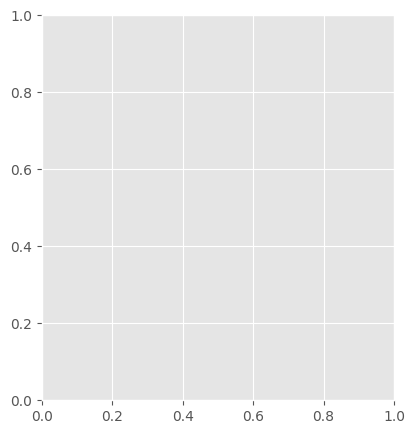

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), loop_info_finetune[0], label='Train')
plt.plot(range(1, num_epochs+1), loop_info_finetune[1], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), loop_info_finetune[2], label='Train')
plt.plot(range(1, num_epochs+1), loop_info_finetune[3], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()

plt.show()

In [ ]:
# Получение метрик качества для текущих весов модели
def evaluate_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    accuracy = np.sum(np.diag(cm)) / np.sum(cm)
    # Вычисление взвешенной F1-меры для текущей модели
    weighted_f1 = f1_score(y_true, y_pred, average='weighted')
    return cm, report, accuracy, weighted_f1

# Функция для построения графика матрицы ошибок
def plot_confusion_matrix(cm, classes):
    with plt.style.context('default'):
        plt.figure(figsize=(5, 4))
        sns.set_theme(font_scale=1.0)
        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False,
                    xticklabels=classes, yticklabels=classes)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.show()

C:\Users\Burn\AppData\Local\Temp\ipykernel_29420\620648811.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Metrics for current model:
              precision    recall  f1-score   support

           0       0.59      0.75      0.66        59
           1       0.72      0.79      0.75        56
           2       0.85      0.61      0.71        28
           3       0.72      0.58      0.64        31
           4       0.80      0.75      0.77        52
           5       0.78      0.87      0.82        53
           6       0.88      0.92      0.90        53
           7       0.86      0.71      0.78        42
           8       0.81      0.92      0.86        51
           9       0.81      0.62      0.70        42
          10       0.92      0.92      0.92        59
          11       0.94      0.88      0.91        33

    accuracy                           0.79       559
   macro avg       0.81      0.78      0.79       559
weighted avg       0.80      0.79      0.79       559

Test Accuracy: 0.7925


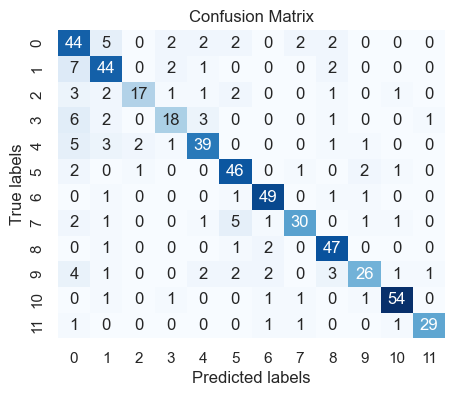

In [ ]:
# Загрузка весов модели
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)

# Оценка модели и построение матрицы ошибок
cm, report, accuracy_1, weighted_f1_1 = evaluate_model(model, val_loader)
print("Metrics for current model:")
print(report)
print(f'Test Accuracy: {accuracy_1:.4f}')
plot_confusion_matrix(cm, classes=list(range(len(classes_list))))

## Модель для transfer learning`а

In [ ]:
class ResNet18ForTransferLearning(nn.Module):

    def __init__(self):
        super().__init__()
        self.resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        for param in self.resnet.parameters():
            param.requires_grad = False

        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)
        self.resnet.fc.requires_grad_(True)

    def forward(self, x):
        return self.resnet(x)

model = ResNet18ForTransferLearning()

In [ ]:
num_epochs = 15
model = ResNet18ForTransferLearning()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loop_info_finetune = train_test_loop(model, criterion, optimizer, num_epochs)

EPOCH 0----------------------------------------------------------------------------------------------------


Test_loss: 1.513 Test_acc: 0.605: 100%|██████████| 9/9 [00:01<00:00,  5.23it/s]


Saved best model!
EPOCH 1----------------------------------------------------------------------------------------------------


Test_loss: 1.195 Test_acc: 0.663: 100%|██████████| 9/9 [00:01<00:00,  5.41it/s]


Saved best model!
EPOCH 2----------------------------------------------------------------------------------------------------


Test_loss: 1.08 Test_acc: 0.685: 100%|██████████| 9/9 [00:01<00:00,  5.56it/s] 


Saved best model!
EPOCH 3----------------------------------------------------------------------------------------------------


Test_loss: 0.978 Test_acc: 0.712: 100%|██████████| 9/9 [00:01<00:00,  5.15it/s]


Saved best model!
EPOCH 4----------------------------------------------------------------------------------------------------


Test_loss: 0.959 Test_acc: 0.721: 100%|██████████| 9/9 [00:01<00:00,  5.68it/s]


Saved best model!
EPOCH 5----------------------------------------------------------------------------------------------------


Test_loss: 0.967 Test_acc: 0.705: 100%|██████████| 9/9 [00:01<00:00,  5.65it/s]


EPOCH 6----------------------------------------------------------------------------------------------------


Test_loss: 0.942 Test_acc: 0.73: 100%|██████████| 9/9 [00:01<00:00,  5.26it/s] 


Saved best model!
EPOCH 7----------------------------------------------------------------------------------------------------


Test_loss: 0.939 Test_acc: 0.723: 100%|██████████| 9/9 [00:01<00:00,  5.02it/s]


EPOCH 8----------------------------------------------------------------------------------------------------


Test_loss: 0.957 Test_acc: 0.714: 100%|██████████| 9/9 [00:01<00:00,  5.34it/s]


EPOCH 9----------------------------------------------------------------------------------------------------


Test_loss: 0.94 Test_acc: 0.743: 100%|██████████| 9/9 [00:01<00:00,  5.00it/s] 


Saved best model!
EPOCH 10----------------------------------------------------------------------------------------------------


Test_loss: 0.93 Test_acc: 0.734: 100%|██████████| 9/9 [00:01<00:00,  4.64it/s] 


EPOCH 11----------------------------------------------------------------------------------------------------


Test_loss: 0.914 Test_acc: 0.734: 100%|██████████| 9/9 [00:01<00:00,  5.12it/s]


EPOCH 12----------------------------------------------------------------------------------------------------


Test_loss: 0.93 Test_acc: 0.723: 100%|██████████| 9/9 [00:01<00:00,  5.58it/s] 


EPOCH 13----------------------------------------------------------------------------------------------------


Test_loss: 0.911 Test_acc: 0.723: 100%|██████████| 9/9 [00:01<00:00,  6.03it/s]


EPOCH 14----------------------------------------------------------------------------------------------------


Test_loss: 0.9 Test_acc: 0.728: 100%|██████████| 9/9 [00:01<00:00,  4.86it/s]  


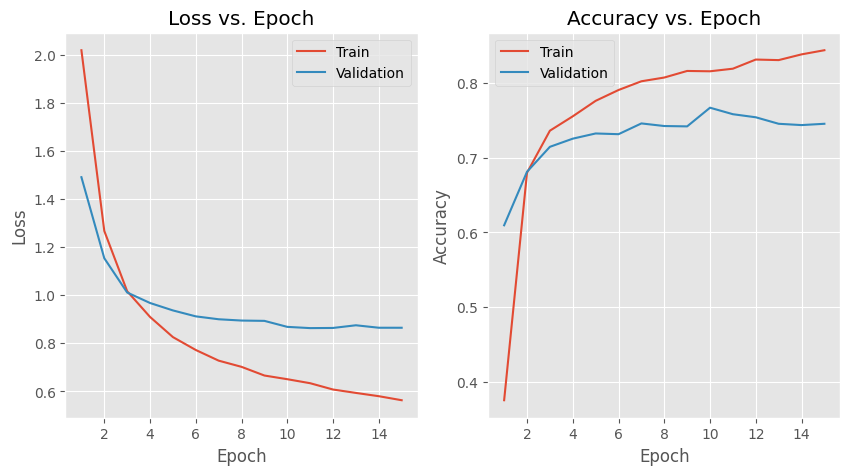

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), loop_info_finetune[0], label='Train')
plt.plot(range(1, num_epochs+1), loop_info_finetune[1], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), loop_info_finetune[2], label='Train')
plt.plot(range(1, num_epochs+1), loop_info_finetune[3], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()

plt.show()

C:\Users\Burn\AppData\Local\Temp\ipykernel_29420\620648811.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Metrics for current model:
              precision    recall  f1-score   support

           0       0.64      0.75      0.69        59
           1       0.69      0.75      0.72        56
           2       0.58      0.54      0.56        28
           3       0.82      0.45      0.58        31
           4       0.72      0.69      0.71        52
           5       0.75      0.81      0.78        53
           6       0.88      0.92      0.90        53
           7       0.77      0.64      0.70        42
           8       0.81      0.92      0.86        51
           9       0.85      0.69      0.76        42
          10       0.83      0.85      0.84        59
          11       0.83      0.91      0.87        33

    accuracy                           0.76       559
   macro avg       0.76      0.74      0.75       559
weighted avg       0.77      0.76      0.76       559

Test Accuracy: 0.7621


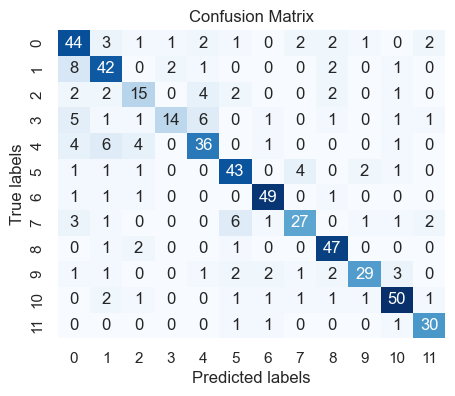

In [ ]:
# Загрузка весов модели
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)

# Оценка модели и построение матрицы ошибок
cm, report, accuracy_1, weighted_f1_1 = evaluate_model(model, val_loader)
print("Metrics for current model:")
print(report)
print(f'Test Accuracy: {accuracy_1:.4f}')
plot_confusion_matrix(cm, classes=list(range(len(classes_list))))

# Добавим аугментаций

In [ ]:
from torchvision.transforms import v2 as transforms

In [ ]:
# Определим трансформации
train_transforms = transforms.Compose([
    transforms.Resize(235),
    transforms.RandomRotation((-3, 3)),
    transforms.CenterCrop(200),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.15, hue=0.15),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToDtype(torch.float, scale=True),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(235),
    transforms.CenterCrop(224),
    transforms.ToDtype(torch.float, scale=True),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Создадим датасеты
train_dataset.transform = train_transforms
val_dataset.transform = val_transforms

# Создадим датагенераторы
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Пример фоток после аугментации:

Images without normalization:


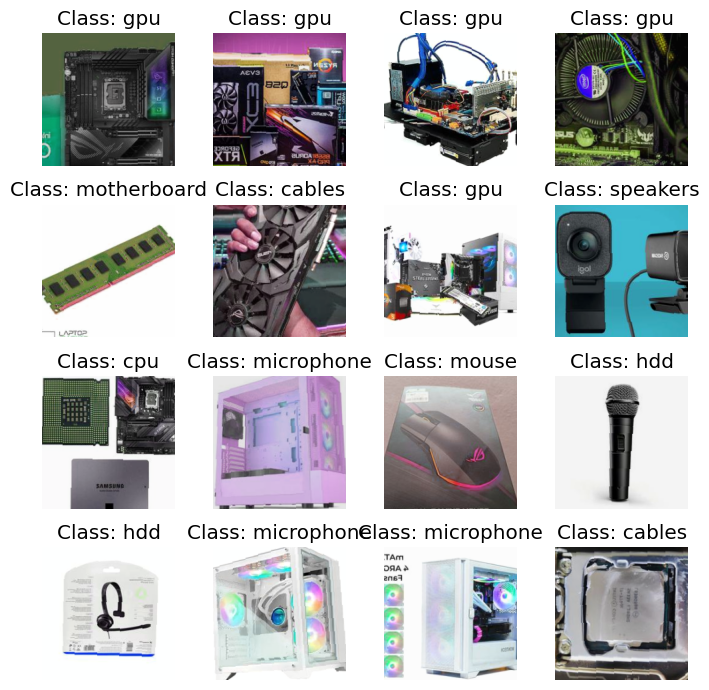

In [ ]:
# Получение первого батча из тренировочного загрузчика данных
images, labels = next(iter(train_loader))

# Отображение изображений с восстановлением цветов
print("Images without normalization:")
show_images(images, labels, denormalize=True)

In [ ]:
num_epochs = 15
model = ResNet18ForFineTune()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loop_info_finetune = train_test_loop(model, criterion, optimizer, num_epochs)

EPOCH 0----------------------------------------------------------------------------------------------------


Test_loss: 1.031 Test_acc: 0.712: 100%|██████████| 9/9 [00:01<00:00,  6.06it/s]


Saved best model!
EPOCH 1----------------------------------------------------------------------------------------------------


Test_loss: 0.845 Test_acc: 0.75: 100%|██████████| 9/9 [00:01<00:00,  5.89it/s] 


Saved best model!
EPOCH 2----------------------------------------------------------------------------------------------------


Test_loss: 0.838 Test_acc: 0.75: 100%|██████████| 9/9 [00:01<00:00,  5.36it/s] 


Saved best model!
EPOCH 3----------------------------------------------------------------------------------------------------


Test_loss: 0.823 Test_acc: 0.761: 100%|██████████| 9/9 [00:01<00:00,  5.60it/s]


Saved best model!
EPOCH 4----------------------------------------------------------------------------------------------------


Test_loss: 0.837 Test_acc: 0.766: 100%|██████████| 9/9 [00:01<00:00,  5.57it/s]


Saved best model!
EPOCH 5----------------------------------------------------------------------------------------------------


Test_loss: 0.848 Test_acc: 0.768: 100%|██████████| 9/9 [00:01<00:00,  5.43it/s]


EPOCH 6----------------------------------------------------------------------------------------------------


Test_loss: 0.87 Test_acc: 0.754: 100%|██████████| 9/9 [00:01<00:00,  5.15it/s] 


EPOCH 7----------------------------------------------------------------------------------------------------


Test_loss: 0.887 Test_acc: 0.775: 100%|██████████| 9/9 [00:01<00:00,  5.52it/s]


EPOCH 8----------------------------------------------------------------------------------------------------


Test_loss: 0.915 Test_acc: 0.768: 100%|██████████| 9/9 [00:01<00:00,  5.59it/s]


EPOCH 9----------------------------------------------------------------------------------------------------


Test_loss: 0.928 Test_acc: 0.77: 100%|██████████| 9/9 [00:01<00:00,  5.89it/s] 


EPOCH 10----------------------------------------------------------------------------------------------------


Test_loss: 0.942 Test_acc: 0.763: 100%|██████████| 9/9 [00:01<00:00,  5.42it/s]


EPOCH 11----------------------------------------------------------------------------------------------------


Test_loss: 0.968 Test_acc: 0.754: 100%|██████████| 9/9 [00:01<00:00,  5.00it/s]


EPOCH 12----------------------------------------------------------------------------------------------------


Test_loss: 0.941 Test_acc: 0.768: 100%|██████████| 9/9 [00:01<00:00,  5.89it/s]


EPOCH 13----------------------------------------------------------------------------------------------------


Test_loss: 0.945 Test_acc: 0.772: 100%|██████████| 9/9 [00:01<00:00,  5.17it/s]


Saved best model!
EPOCH 14----------------------------------------------------------------------------------------------------


Test_loss: 0.973 Test_acc: 0.763: 100%|██████████| 9/9 [00:01<00:00,  4.99it/s]


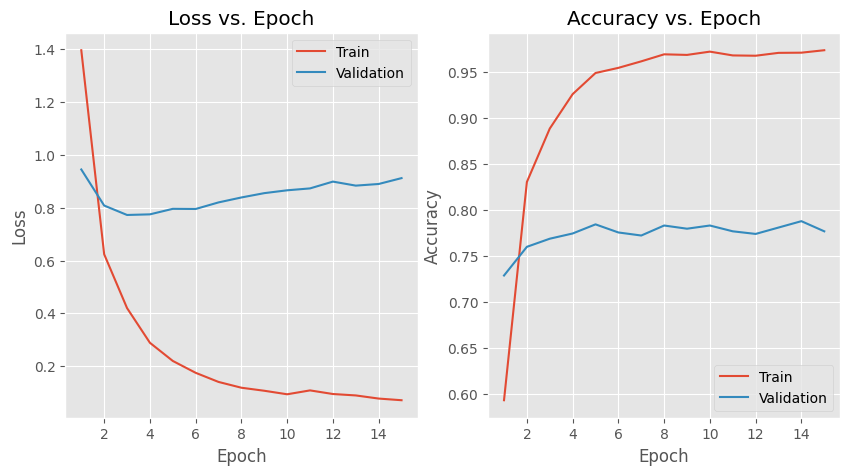

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), loop_info_finetune[0], label='Train')
plt.plot(range(1, num_epochs+1), loop_info_finetune[1], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), loop_info_finetune[2], label='Train')
plt.plot(range(1, num_epochs+1), loop_info_finetune[3], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()

plt.show()

C:\Users\Burn\AppData\Local\Temp\ipykernel_29420\620648811.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Metrics for current model:
              precision    recall  f1-score   support

           0       0.65      0.71      0.68        59
           1       0.72      0.73      0.73        56
           2       0.85      0.61      0.71        28
           3       0.64      0.68      0.66        31
           4       0.71      0.77      0.74        52
           5       0.80      0.81      0.80        53
           6       0.79      0.92      0.85        53
           7       0.86      0.71      0.78        42
           8       0.81      0.90      0.85        51
           9       0.89      0.74      0.81        42
          10       0.91      0.86      0.89        59
          11       0.97      0.85      0.90        33

    accuracy                           0.79       559
   macro avg       0.80      0.78      0.78       559
weighted avg       0.79      0.79      0.79       559

Test Accuracy: 0.7853


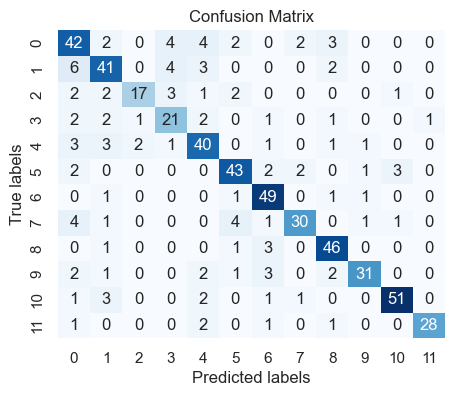

In [ ]:
# Загрузка весов модели
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)

# Оценка модели и построение матрицы ошибок
cm, report, accuracy_1, weighted_f1_1 = evaluate_model(model, val_loader)
print("Metrics for current model:")
print(report)
print(f'Test Accuracy: {accuracy_1:.4f}')
plot_confusion_matrix(cm, classes=list(range(len(classes_list))))

## Как написать кастомный лосс:

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    @torch.compile
    def forward(self, inputs, targets):
        ce_loss = torch.nn.functional.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return torch.mean(focal_loss)
        elif self.reduction == 'sum':
            return torch.sum(focal_loss)
        else:
            return focal_loss

# criterion = FocalLoss()

---

# Инференс готовой модели

In [ ]:
# Загрузим предварительно обученную модель ResNet18
model = ResNet18ForFineTune()
model.load_state_dict(torch.load('best_model.pth'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

# Предобработка изображения
preprocess = transforms.Compose([
    transforms.Resize(235),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

C:\Users\Burn\AppData\Local\Temp\ipykernel_29420\2002153547.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))
e:\OTUS\v

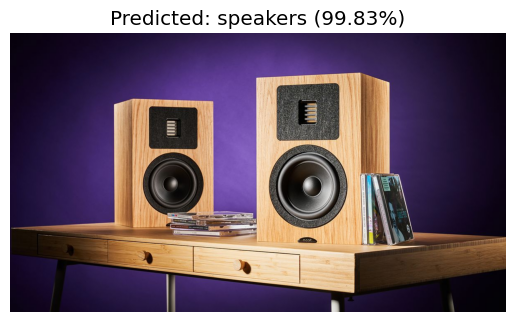

In [ ]:
# Загрузите изображение для инференса
image_path = 'test2.jpg'  # Замените на путь к вашему изображению
image = Image.open(image_path)
image_tensor = preprocess(image)
image_tensor = image_tensor.unsqueeze(0).to(device)  # Добавляем размер батча

# Прогоните изображение через модель
with torch.no_grad():
    output = model(image_tensor)

# Примените softmax для получения вероятностей классов
probabilities = torch.nn.functional.softmax(output[0], dim=0).cpu()

# Отображение результатов
top_prob, top_class = torch.topk(probabilities, 1)
top_prob = top_prob.item()
top_class = top_class.item()

# Получить имя класса
class_name = train_dataset.classes[top_class]

# Отобразить изображение
plt.imshow(image)
plt.axis('off')
plt.title(f'Predicted: {class_name} ({top_prob*100:.2f}%)')
plt.show()

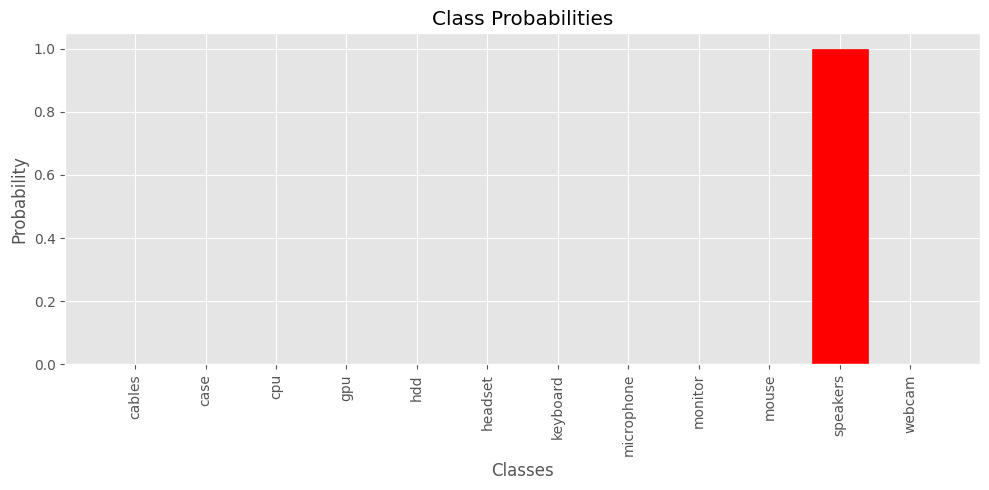

In [ ]:
# Построить барплот
plt.figure(figsize=(10, 5))
bars = plt.bar(range(len(probabilities)), probabilities, color='blue')
plt.xlabel('Classes')
plt.ylabel('Probability')
plt.title('Class Probabilities')
plt.xticks(range(len(probabilities)), train_dataset.classes, rotation='vertical')

# Подсветить класс с наибольшей уверенностью
bars[top_class].set_color('red')

plt.tight_layout()
plt.show()

https://pytorch.org/tutorials/intermediate/torch_compile_tutorial.html

https://pytorch.org/tutorials/advanced/cpp_export.html

https://onnxruntime.ai/docs/get-started/with-cpp.html

https://pytorch.org/tutorials/advanced/super_resolution_with_onnxruntime.html

https://docs.nvidia.com/deeplearning/tensorrt/developer-guide/index.html